Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [2]:
# Read in the data sets
df = pd.read_csv("data/nat2019slice.csv")

In [3]:
df.columns

Index(['dob_yy', 'dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'f_facility',
       'bfacil3', 'mage_impflg', 'mage_repflg', 'mager',
       ...
       'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom', 'f_ca_hypos',
       'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed'],
      dtype='object', length=226)

In [4]:
df.head()

,dob_yy,dob_mm,dob_tt,dob_wk,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,...,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen,itran,ilive,bfed,f_bfed
0,2019,1,1135,3,1,1,1,NaN,NaN,29,...,1,1,1,1,1,1,N,Y,Y,1
1,2019,1,1305,3,1,1,1,NaN,NaN,40,...,1,1,1,1,1,1,N,Y,Y,1
2,2019,1,800,3,1,1,1,NaN,NaN,30,...,1,1,1,1,1,1,N,Y,Y,1
3,2019,1,130,4,1,1,1,NaN,NaN,25,...,1,1,1,1,1,1,N,Y,Y,1
4,2019,1,1426,4,1,1,1,NaN,NaN,38,...,1,1,1,1,1,1,N,Y,Y,1


Columns are removed for the following reasons:
- They are storing metadata about the collection of the data minor processing tasks performed
- They are pre-binned for a specific purpose outside the scope of this analysis
- They are slight variations of existing columns which are more applicable to this analysis
- They represent events that happen after birth has already occurred

In [5]:
remove = ['dob_yy', 'f_facility', 'bfacil3', 'mage_impflg', 'mage_repflg', 'mager14', 'mager9', 'mrace31', 'mrace6', 'mrace15',
           'mraceimp', 'mhispx', 'f_mhisp', 'mracehisp', 'mar_p', 'mar_imp', 'f_mar_p', 'f_meduc', 'fagerpt_flg', 'fagerec11',
           'frace31', 'frace15', 'fhispx', 'f_fhisp', 'lbo_rec', 'tbo_rec', 'illb_r', 'illb_r11', 'ilop_r',
           'ilop_r11', 'ilp_r11', 'f_mpcb', 'precare5', 'previs_rec', 'f_tpcv', 'f_wic', 'cig0_r', 'cig1_r', 'cig2_r',
           'cig3_r', 'f_cigs_0', 'f_cigs_1', 'f_cigs_2', 'f_cigs_3', 'cig_rec', 'f_tobaco', 'f_m_ht', 'bmi_r', 'pwgt_r',
           'f_pwgt', 'f_dwgt', 'wtgain_rec', 'f_wtgain', 'f_rf_pdiab', 'f_rf_gdiab', 'f_rf_phyper', 'f_rf_ghyper', 
           'f_rf_eclamp', 'f_rf_ppb', 'f_rf_inf_drg', 'f_rf_inf_art', 'rf_cesar', 'f_rf_cesar', 'f_rf_ncesar',
           'no_risks', 'f_ip_gonor', 'f_ip_syph', 'f_ip_chlam', 'f_ip_hepatb', 'f_ip_hepatc', 'no_infec', 'ob_ecvs', 'ob_ecvf',
           'f_ob_succ', 'f_ob_fail', 'ld_indl', 'ld_augm', 'ld_anes', 'f_ld_indl', 'f_ld_augm', 'f_ld_ster', 'f_ld_antb',
           'f_ld_chor', 'f_ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial', 'f_me_pres', 'f_me_rout', 'f_me_trial',
           'rdmeth_rec', 'dmeth_rec', 'f_dmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'f_mm_mtr',
           'f_mm_rupt', 'f_mm_uhyst', 'f_mm_aicu', 'no_mmorb', 'mtran', 'pay', 'f_pay', 'f_pay_rec', 'apgar5r',
           'f_apgar5', 'apgar10', 'apgar10r', 'imp_plur', 'setorder_r', 'imp_sex', 'dlmp_mm', 'dlmp_yy', 'compgst_imp',
           'obgest_flg', 'gestrec10', 'gestrec3', 'lmpused', 'oegest_comb', 'oegest_r10', 'dbwt', 'bwtr12', 'bwtr4',
           'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'f_ab_vent', 'f_ab_vent6',
           'f_ab_surfac', 'f_ab_antibio', 'f_ab_seiz', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 
           'ca_gast', 'f_ca_anen', 'f_ca_menin', 'f_ca_heart', 'f_ca_hernia', 'f_ca_ompha', 'f_ca_gastro', 'ca_limb',
           'ca_cleft', 'ca_clpal', 'ca_disor', 'ca_hypo', 'f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 
           'f_ca_chrom', 'f_ca_hypos', 'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed', 'f_mm_', 'f_ab_nicu', 'fracehisp',
           'oegest_r3', 'dob_mm', 'dob_tt', 'dob_wk', 'restatus', 'frace6', 'fhisp_r', 'feduc', 'ilp_r', 'attend', 'pay_rec']

In [6]:
df.drop(remove, axis=1, inplace=True)
df.columns

Index(['bfacil', 'mager', 'mbstate_rec', 'mbrace', 'mhisp_r', 'dmar', 'meduc',
       'fagecomb', 'priorlive', 'priordead', 'priorterm', 'precare', 'previs',
       'wic', 'cig_0', 'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'bmi', 'dwgt_r',
       'wtgain', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype',
       'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'rf_cesarn', 'ip_gon',
       'ip_syph', 'ip_chlam', 'ip_hepatb', 'ip_hepatc', 'ld_ster', 'ld_antb',
       'ld_chor', 'apgar5', 'dplural', 'sex', 'combgest', 'ca_downs'],
      dtype='object')

In [7]:
rename = ['birth_place', 'mother_age', 'mother_native',
          'mother_race', 'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
          'living_children', 'deceased_children', 'terminations', 
          'months_prenatal_care', 'prenatal_visits', 'food_assistance', 'prepregnancy_daily_cig',
          'first_tri_daily_cig', 'second_tri_daily_cig', 'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
          'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension', 'gestational_hypertension', 'eclampsia',
          'previous_premature_birth', 'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
          'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
          'chorioamnionitis', 'apgar_score', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
          'down_syndrome']

In [8]:
df.columns = rename

## Target Engineering

In [9]:
df['apgar_score'].value_counts()

9     362
8     100
10      9
7       9
6       6
5       5
1       3
99      2
3       2
4       1
Name: apgar_score, dtype: int64

In [10]:
df['apgar_score'].replace(to_replace=list(range(0, 7)), value=0, inplace=True)

In [11]:
df['apgar_score'].replace(to_replace=list(range(7, 11)), value=1, inplace=True)

In [12]:
df.drop(df.loc[df['apgar_score']==99].index, inplace=True)

In [13]:
df['apgar_score'].value_counts()

1    480
0     17
Name: apgar_score, dtype: int64

## Feature Processing

In [14]:
df.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'apgar_score', 'plural_pregnancy', 'infant_sex',
       'weeks_gestation', 'down_syndrome'],
      dtype='object')

In [15]:
df['birth_place'].value_counts()

1    478
2     13
3      5
4      1
Name: birth_place, dtype: int64

In [16]:
df['birth_place'].replace(to_replace=list(range(2, 8)), value="other", inplace=True)
df['birth_place'].replace(to_replace=1, value="hospital", inplace=True)
df['birth_place'].replace(to_replace=9, value=np.nan, inplace=True)

In [17]:
df['mother_native'].value_counts()

1    436
2     60
3      1
Name: mother_native, dtype: int64

In [18]:
df['mother_native'].replace(to_replace=2, value=0, inplace=True)
df['mother_native'].replace(to_replace=3, value=np.nan, inplace=True)

In [19]:
df['mother_race'].value_counts()

1    308
3    110
4     57
2     22
Name: mother_race, dtype: int64

In [20]:
df['mother_race'].replace({1: 'white', 2: 'black', 3: 'native_american', 4: 'asian/pi'}, inplace=True)

In [21]:
# Place of birth
counts = (df[['mother_race', 'apgar_score']]
              .groupby(['mother_race', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

In [22]:
counts['percent_low_apgar'] = (counts[0]/counts[1])*100

In [23]:
counts['percent_low_apgar']

mother_race
asian/pi           11.764706
black               4.761905
native_american     1.851852
white               2.666667
Name: percent_low_apgar, dtype: float64

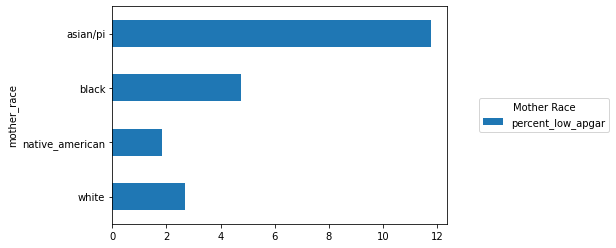

In [24]:
ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Mother Race'
)

In [25]:
df['mother_hispanic'].value_counts()

0    446
1     18
5     10
9      8
4      7
2      6
3      2
Name: mother_hispanic, dtype: int64

In [26]:
df['mother_hispanic'].replace(to_replace=list(range(1, 6)), value=1, inplace=True)
df['mother_hispanic'].replace(to_replace=9, value=np.nan, inplace=True)

In [27]:
df['marital_status'].value_counts()

1    310
2    187
Name: marital_status, dtype: int64

In [28]:
df['marital_status'].replace({1: 'married', 2: 'unmarried'}, inplace=True)

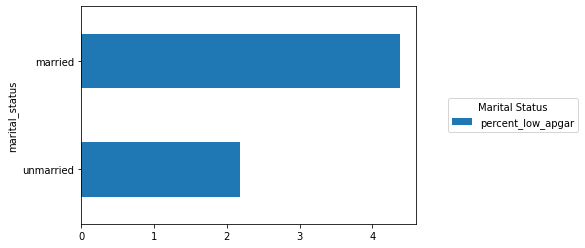

In [29]:
counts = (df[['marital_status', 'apgar_score']]
              .groupby(['marital_status', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Marital Status'
)

In [30]:
df['mother_education'].value_counts()

3    138
4    128
6     90
5     44
2     42
7     26
8     13
9      9
1      7
Name: mother_education, dtype: int64

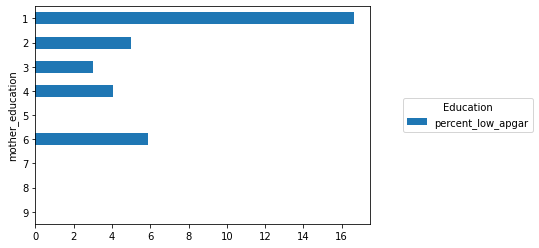

In [31]:
counts = (df[['mother_education', 'apgar_score']]
              .groupby(['mother_education', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Education'
)

In [32]:
df['mother_education'].replace(to_replace=list(range(1, 6)), value="hs_or_lower", inplace=True)
df['mother_education'].replace(to_replace=list(range(6, 9)), value="college_or_higher", inplace=True)
df['mother_education'].replace(to_replace=9, value=np.nan, inplace=True)

In [33]:
df['father_age'].value_counts()

99    43
31    39
34    26
33    25
27    24
38    23
32    23
36    22
28    21
29    21
26    20
30    20
22    20
25    17
35    16
37    16
21    15
41    15
39    11
40    10
24    10
20     8
23     6
47     6
42     5
46     5
43     5
49     4
44     4
52     3
51     3
48     2
45     2
19     2
18     2
55     1
53     1
58     1
Name: father_age, dtype: int64

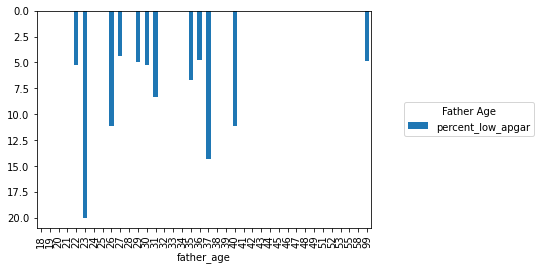

In [34]:
counts = (df[['father_age', 'apgar_score']]
              .groupby(['father_age', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Father Age'
)

In [35]:
df['father_age'].replace(to_replace=99, value=np.nan, inplace=True)

In [36]:
df['living_children'].value_counts()

0     168
1     147
2      92
3      49
4      21
5       9
6       5
7       2
99      1
10      1
9       1
8       1
Name: living_children, dtype: int64

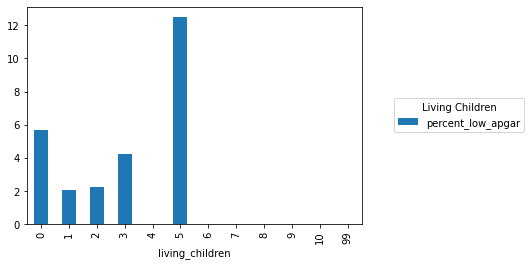

In [37]:
counts = (df[['living_children', 'apgar_score']]
              .groupby(['living_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Living Children'
)

In [38]:
df['living_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [39]:
df['deceased_children'].value_counts()

0     490
1       5
99      1
2       1
Name: deceased_children, dtype: int64

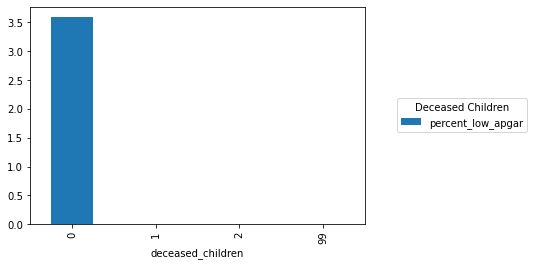

In [40]:
counts = (df[['deceased_children', 'apgar_score']]
              .groupby(['deceased_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Deceased Children'
)

In [41]:
df['deceased_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [42]:
df['terminations'].value_counts()

0     322
1     100
2      38
3      14
4       9
99      6
7       3
5       3
9       1
8       1
Name: terminations, dtype: int64

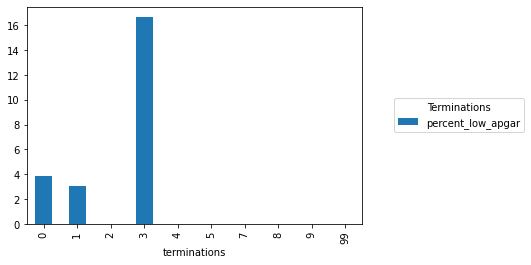

In [43]:
counts = (df[['terminations', 'apgar_score']]
              .groupby(['terminations', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Terminations'
)

In [44]:
df['terminations'].replace(to_replace=99, value=np.nan, inplace=True)

In [45]:
df['months_prenatal_care'].value_counts()

2     177
3     169
4      57
99     28
5      22
8      10
6      10
7       9
1       8
0       5
9       2
Name: months_prenatal_care, dtype: int64

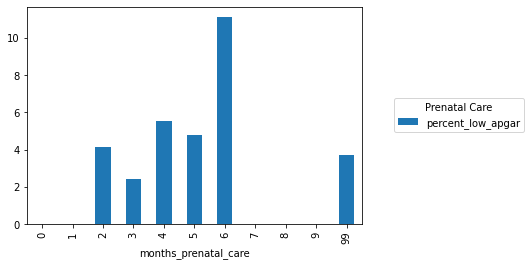

In [46]:
counts = (df[['months_prenatal_care', 'apgar_score']]
              .groupby(['months_prenatal_care', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Care'
)

In [47]:
df['months_prenatal_care'].replace(to_replace=99, value=np.nan, inplace=True)

In [48]:
df['prenatal_visits'].value_counts()

10    65
11    61
8     40
12    39
9     39
13    35
7     31
99    30
14    25
6     21
15    18
5     15
4     14
16    12
17    10
3      8
2      6
19     5
0      5
18     4
1      3
22     2
21     2
20     2
23     2
27     1
28     1
30     1
Name: prenatal_visits, dtype: int64

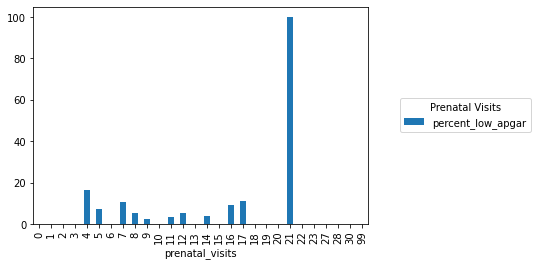

In [49]:
counts = (df[['prenatal_visits', 'apgar_score']]
              .groupby(['prenatal_visits', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Visits'
)

In [50]:
df['prenatal_visits'].replace(to_replace=99, value=np.nan, inplace=True)

In [51]:
df['food_assistance'].value_counts()

N    328
Y    160
U      9
Name: food_assistance, dtype: int64

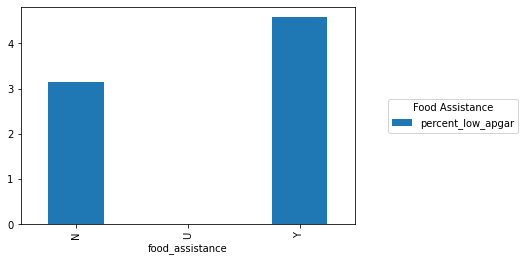

In [52]:
counts = (df[['food_assistance', 'apgar_score']]
              .groupby(['food_assistance', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

In [53]:
df['prenatal_visits'].replace(to_replace='U', value=np.nan, inplace=True)

In [54]:
df['prepregnancy_daily_cig'].value_counts()

0     411
99     18
10     18
20     11
7       7
5       6
8       5
4       4
3       4
2       3
40      2
15      2
9       2
6       2
80      1
1       1
Name: prepregnancy_daily_cig, dtype: int64

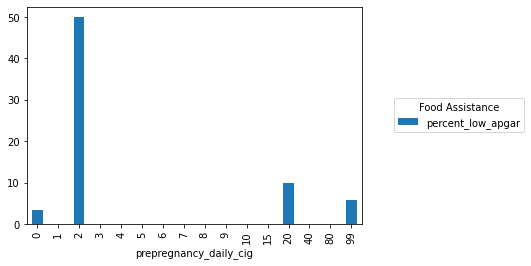

In [55]:
counts = (df[['prepregnancy_daily_cig', 'apgar_score']]
              .groupby(['prepregnancy_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

In [56]:
df['first_tri_daily_cig'].value_counts()

0     428
99     17
10     13
5       9
4       6
6       4
20      3
8       3
7       3
2       3
9       2
3       2
40      1
15      1
12      1
1       1
Name: first_tri_daily_cig, dtype: int64

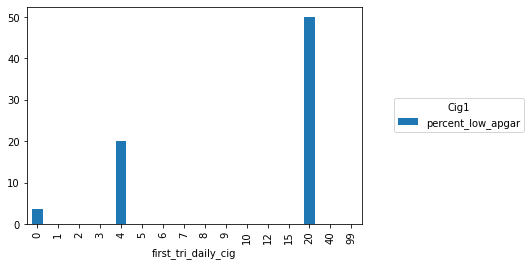

In [57]:
counts = (df[['first_tri_daily_cig', 'apgar_score']]
              .groupby(['first_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig1'
)

In [58]:
df['first_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [59]:
df['second_tri_daily_cig'].value_counts()

0     429
99     20
5      12
10     11
3       6
8       4
20      3
6       3
15      2
2       2
1       2
9       1
7       1
4       1
Name: second_tri_daily_cig, dtype: int64

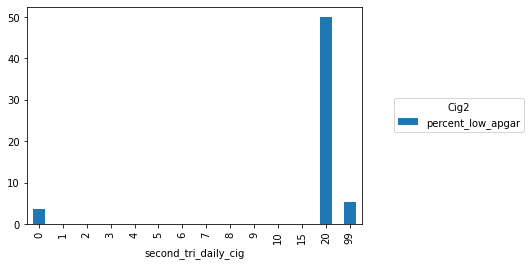

In [60]:
counts = (df[['second_tri_daily_cig', 'apgar_score']]
              .groupby(['second_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig2'
)

In [61]:
df['second_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [62]:
df['third_tri_daily_cig'].value_counts()

0     429
99     23
10      9
5       9
6       5
4       5
7       4
2       4
20      3
1       2
15      1
9       1
8       1
3       1
Name: third_tri_daily_cig, dtype: int64

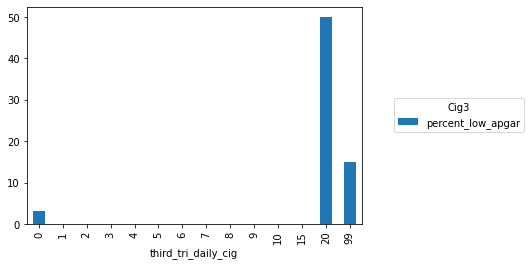

In [63]:
counts = (df[['third_tri_daily_cig', 'apgar_score']]
              .groupby(['third_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [64]:
df['third_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [65]:
df['height'].value_counts()

64    89
63    71
62    56
66    55
67    53
65    53
68    24
61    24
60    24
59    12
69    10
70     9
58     5
71     5
57     2
73     2
56     2
72     1
Name: height, dtype: int64

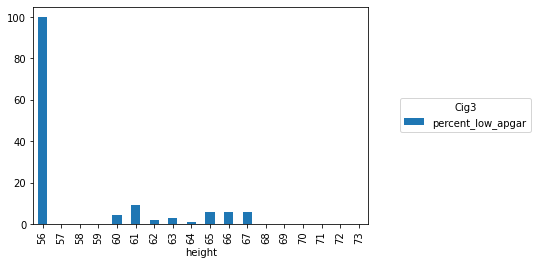

In [66]:
counts = (df[['height', 'apgar_score']]
              .groupby(['height', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [67]:
df['height'].replace(to_replace=99, value=np.nan, inplace=True)

In [68]:
df['bmi'].value_counts()

99.9    10
22.9    10
26.6     9
28.3     9
21.5     8
        ..
25.4     1
29.2     1
24.8     1
19.2     1
28.8     1
Name: bmi, Length: 194, dtype: int64

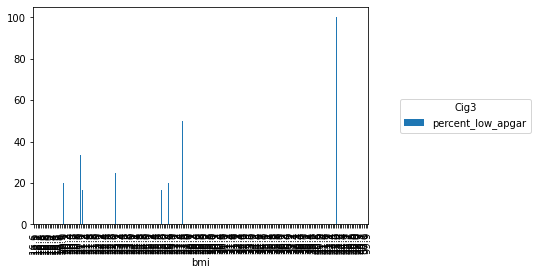

In [69]:
counts = (df[['bmi', 'apgar_score']]
              .groupby(['bmi', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [70]:
df['bmi'].replace(to_replace=99, value=np.nan, inplace=True)

In [71]:
df['delivery_weight'].value_counts()

999    10
188    10
168    10
160    10
195     9
       ..
400     1
305     1
310     1
318     1
227     1
Name: delivery_weight, Length: 153, dtype: int64

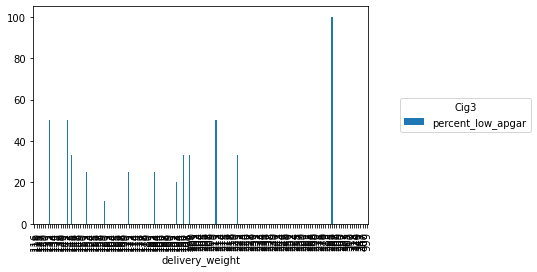

In [72]:
counts = (df[['delivery_weight', 'apgar_score']]
              .groupby(['delivery_weight', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [73]:
df['delivery_weight'].replace(to_replace=999, value=np.nan, inplace=True)

In [74]:
df['weight_gain'].value_counts()

0     27
30    24
99    21
24    19
33    19
      ..
71     1
73     1
78     1
77     1
66     1
Name: weight_gain, Length: 80, dtype: int64

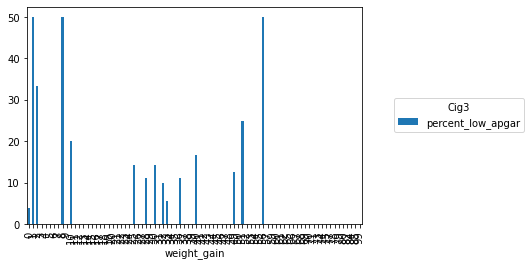

In [75]:
counts = (df[['weight_gain', 'apgar_score']]
              .groupby(['weight_gain', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [76]:
df['weight_gain'].replace(to_replace=99, value=np.nan, inplace=True)

In [77]:
df['diabetes'].value_counts()

N    487
Y      7
U      3
Name: diabetes, dtype: int64

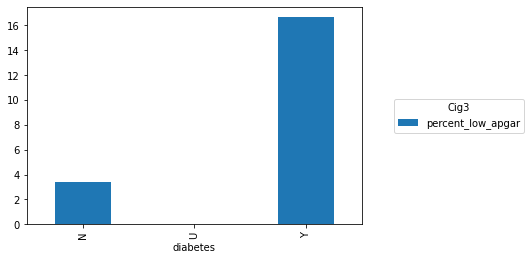

In [78]:
counts = (df[['diabetes', 'apgar_score']]
              .groupby(['diabetes', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [79]:
df['diabetes'].replace(to_replace='U', value=np.nan, inplace=True)

In [80]:
df['gestational_diabetes'].value_counts()

N    435
Y     59
U      3
Name: gestational_diabetes, dtype: int64

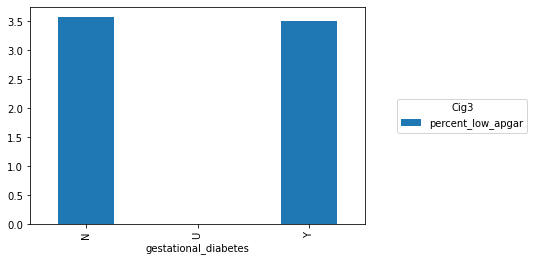

In [81]:
counts = (df[['gestational_diabetes', 'apgar_score']]
              .groupby(['gestational_diabetes', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [82]:
df['gestational_diabetes'].replace(to_replace='U', value=np.nan, inplace=True)

In [83]:
df['hypertension'].value_counts()

N    473
Y     21
U      3
Name: hypertension, dtype: int64

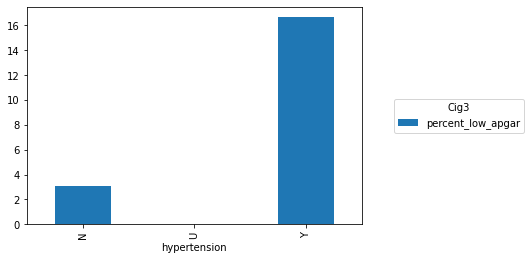

In [84]:
counts = (df[['hypertension', 'apgar_score']]
              .groupby(['hypertension', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [85]:
df['hypertension'].replace(to_replace='U', value=np.nan, inplace=True)

In [86]:
df['gestational_hypertension'].value_counts()

N    439
Y     55
U      3
Name: gestational_hypertension, dtype: int64

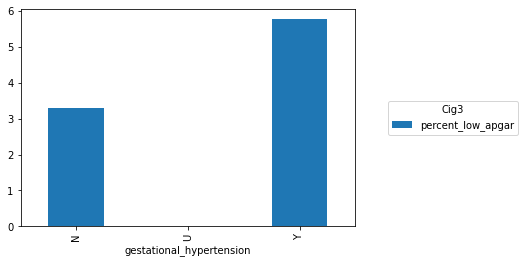

In [87]:
counts = (df[['gestational_hypertension', 'apgar_score']]
              .groupby(['gestational_hypertension', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [88]:
df['gestational_hypertension'].replace(to_replace='U', value=np.nan, inplace=True)

In [89]:
df['eclampsia'].value_counts()

N    493
U      3
Y      1
Name: eclampsia, dtype: int64

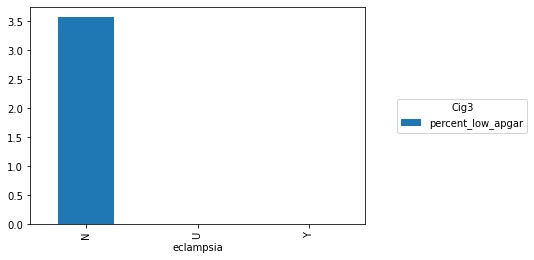

In [90]:
counts = (df[['eclampsia', 'apgar_score']]
              .groupby(['eclampsia', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [91]:
df['eclampsia'].replace(to_replace='U', value=np.nan, inplace=True)

In [92]:
df['previous_premature_birth'].value_counts()

N    475
Y     19
U      3
Name: previous_premature_birth, dtype: int64

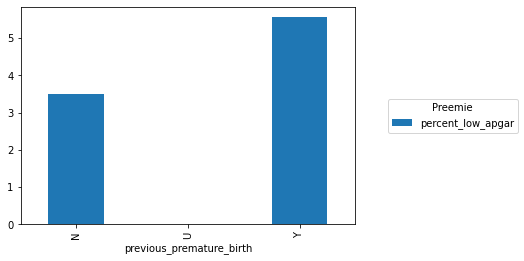

In [93]:
counts = (df[['previous_premature_birth', 'apgar_score']]
              .groupby(['previous_premature_birth', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [94]:
df['previous_premature_birth'].replace(to_replace='U', value=np.nan, inplace=True)

In [95]:
df['infertility_treatment'].value_counts()

N    486
Y      8
U      3
Name: infertility_treatment, dtype: int64

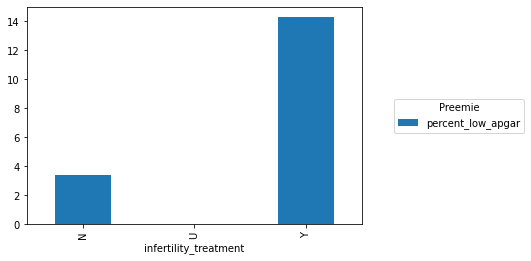

In [96]:
counts = (df[['infertility_treatment', 'apgar_score']]
              .groupby(['infertility_treatment', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [97]:
df['infertility_treatment'].replace(to_replace='U', value=np.nan, inplace=True)

In [98]:
df['fertility_drugs'].value_counts()

X    486
N      6
U      3
Y      2
Name: fertility_drugs, dtype: int64

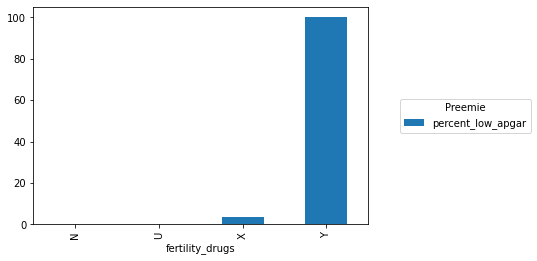

In [99]:
counts = (df[['fertility_drugs', 'apgar_score']]
              .groupby(['fertility_drugs', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [100]:
df['fertility_drugs'].replace(to_replace='U', value=np.nan, inplace=True)
df['fertility_drugs'].replace(to_replace='X', value='N', inplace=True)

In [101]:
df['assisted_reproduction'].value_counts()

X    486
Y      6
U      3
N      2
Name: assisted_reproduction, dtype: int64

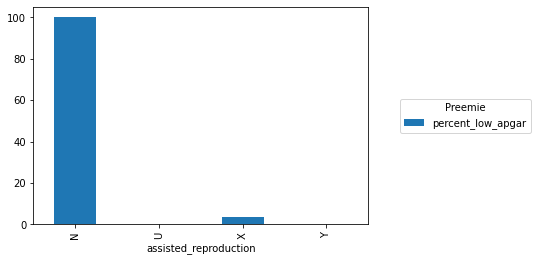

In [102]:
counts = (df[['assisted_reproduction', 'apgar_score']]
              .groupby(['assisted_reproduction', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [103]:
df['assisted_reproduction'].replace(to_replace='U', value=np.nan, inplace=True)
df['assisted_reproduction'].replace(to_replace='X', value='N', inplace=True)

In [104]:
df['previous_cesareans'].value_counts()

0     437
1      35
2      11
3      10
99      4
Name: previous_cesareans, dtype: int64

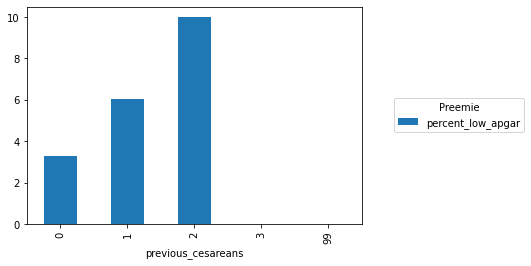

In [105]:
counts = (df[['previous_cesareans', 'apgar_score']]
              .groupby(['previous_cesareans', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [106]:
df['previous_cesareans'].replace(to_replace=99, value=np.nan, inplace=True)

In [107]:
df['gonorrhea'].value_counts()

N    487
U      9
Y      1
Name: gonorrhea, dtype: int64

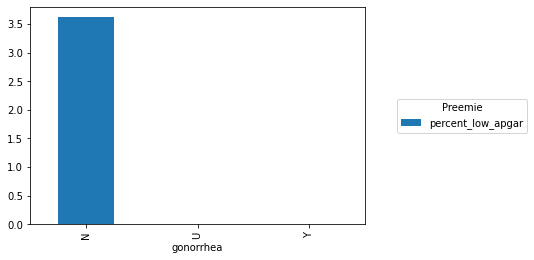

In [108]:
counts = (df[['gonorrhea', 'apgar_score']]
              .groupby(['gonorrhea', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [109]:
df['gonorrhea'].replace(to_replace='U', value=np.nan, inplace=True)

In [110]:
df['syphilis'].value_counts()

N    488
U      9
Name: syphilis, dtype: int64

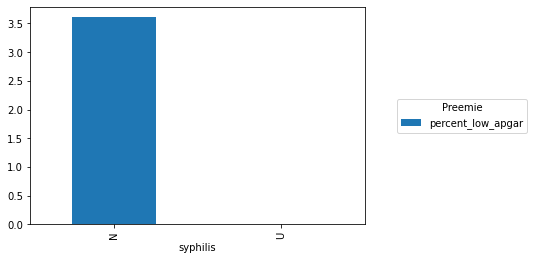

In [111]:
counts = (df[['syphilis', 'apgar_score']]
              .groupby(['syphilis', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [112]:
df['syphilis'].replace(to_replace='U', value=np.nan, inplace=True)

In [113]:
df['chlamydia'].value_counts()

N    472
Y     16
U      9
Name: chlamydia, dtype: int64

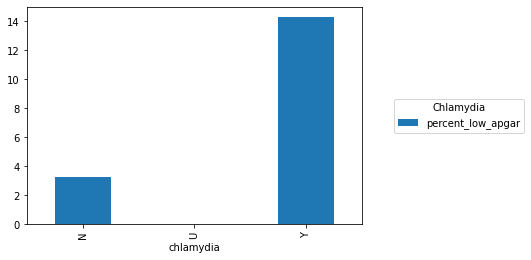

In [114]:
counts = (df[['chlamydia', 'apgar_score']]
              .groupby(['chlamydia', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Chlamydia'
)

In [115]:
df['chlamydia'].replace(to_replace='U', value=np.nan, inplace=True)

In [116]:
df['hepatitis_b'].value_counts()

N    484
U      9
Y      4
Name: hepatitis_b, dtype: int64

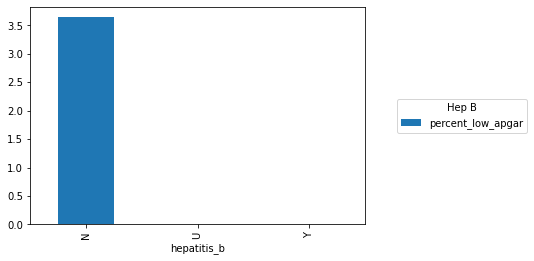

In [117]:
counts = (df[['hepatitis_b', 'apgar_score']]
              .groupby(['hepatitis_b', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Hep B'
)

In [118]:
df['hepatitis_b'].replace(to_replace='U', value=np.nan, inplace=True)

In [119]:
df['hepatitis_c'].value_counts()

N    477
Y     11
U      9
Name: hepatitis_c, dtype: int64

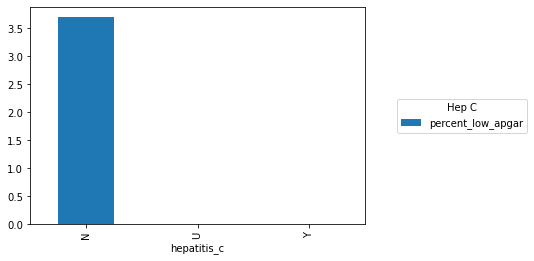

In [120]:
counts = (df[['hepatitis_c', 'apgar_score']]
              .groupby(['hepatitis_c', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Hep C'
)

In [121]:
df['hepatitis_c'].replace(to_replace='U', value=np.nan, inplace=True)

In [122]:
df['steroids'].value_counts()

N    457
Y     40
Name: steroids, dtype: int64

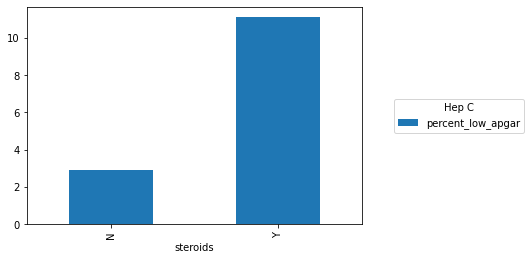

In [123]:
counts = (df[['steroids', 'apgar_score']]
              .groupby(['steroids', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Hep C'
)

In [124]:
df['steroids'].replace(to_replace='U', value=np.nan, inplace=True)

In [125]:
df['antibiotics'].value_counts()

N    341
Y    156
Name: antibiotics, dtype: int64

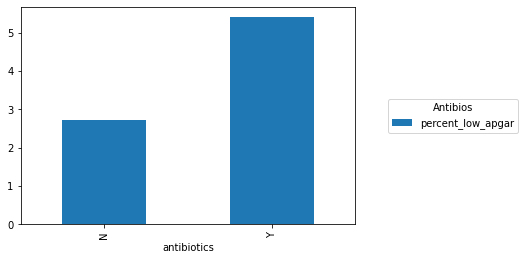

In [126]:
counts = (df[['antibiotics', 'apgar_score']]
              .groupby(['antibiotics', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Antibios'
)

In [127]:
df['antibiotics'].replace(to_replace='U', value=np.nan, inplace=True)

In [128]:
df['chorioamnionitis'].value_counts()

N    487
Y     10
Name: chorioamnionitis, dtype: int64

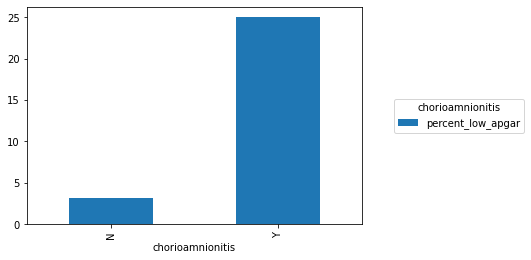

In [129]:
counts = (df[['chorioamnionitis', 'apgar_score']]
              .groupby(['chorioamnionitis', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='chorioamnionitis'
)

In [130]:
df['chorioamnionitis'].replace(to_replace='U', value=np.nan, inplace=True)

In [131]:
df['apgar_score'].value_counts()

1    480
0     17
Name: apgar_score, dtype: int64

In [132]:
df['plural_pregnancy'].value_counts()

1    479
2     18
Name: plural_pregnancy, dtype: int64

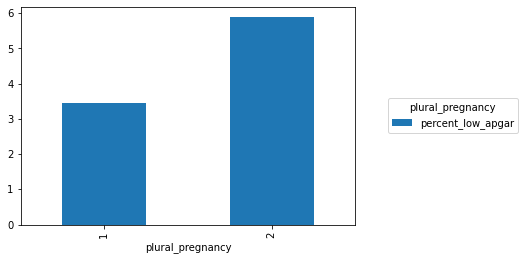

In [133]:
counts = (df[['plural_pregnancy', 'apgar_score']]
              .groupby(['plural_pregnancy', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='plural_pregnancy'
)

In [134]:
df['infant_sex'].value_counts()

M    249
F    248
Name: infant_sex, dtype: int64

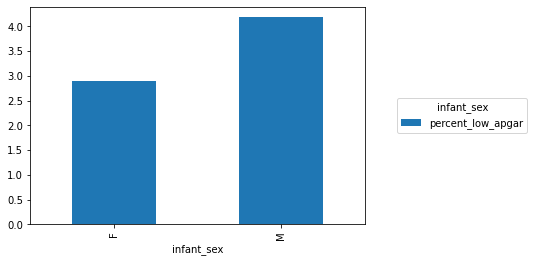

In [135]:
counts = (df[['infant_sex', 'apgar_score']]
              .groupby(['infant_sex', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='infant_sex'
)

In [136]:
df['weeks_gestation'].value_counts()

39    136
40    102
38     78
37     56
41     32
36     28
43     10
35     10
34     10
42      9
33      8
44      6
32      5
29      4
31      1
24      1
23      1
Name: weeks_gestation, dtype: int64

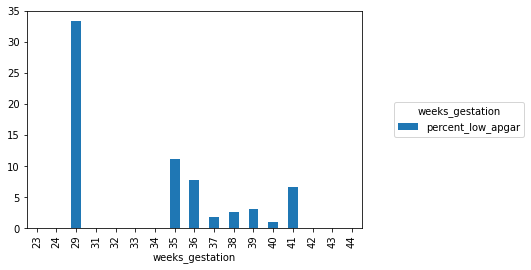

In [137]:
counts = (df[['weeks_gestation', 'apgar_score']]
              .groupby(['weeks_gestation', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='weeks_gestation'
)

In [138]:
df['weeks_gestation'].replace(to_replace=99, value=np.nan, inplace=True)

In [139]:
df['down_syndrome'].value_counts()

N    497
Name: down_syndrome, dtype: int64

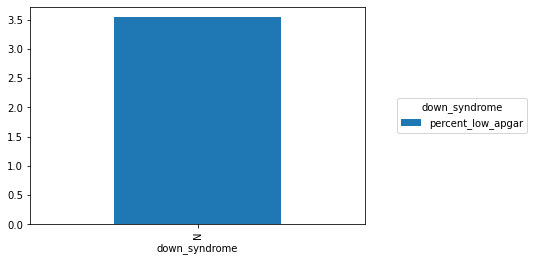

In [140]:
counts = (df[['down_syndrome', 'apgar_score']]
              .groupby(['down_syndrome', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='down_syndrome'
)

In [141]:
df['down_syndrome'].replace(to_replace='U', value=np.nan, inplace=True)

In [142]:
df['down_syndrome'].replace(to_replace='P', value='C', inplace=True)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 498
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   birth_place               497 non-null    object 
 1   mother_age                497 non-null    int64  
 2   mother_native             496 non-null    float64
 3   mother_race               497 non-null    object 
 4   mother_hispanic           489 non-null    float64
 5   marital_status            497 non-null    object 
 6   mother_education          488 non-null    object 
 7   father_age                454 non-null    float64
 8   living_children           496 non-null    float64
 9   deceased_children         496 non-null    float64
 10  terminations              491 non-null    float64
 11  months_prenatal_care      469 non-null    float64
 12  prenatal_visits           467 non-null    float64
 13  food_assistance           497 non-null    object 
 14  prepregnan

In [144]:
df_cat = df.select_dtypes(include=['object'])

In [145]:
df_num = df.select_dtypes(include=['int64', 'float64'])

In [146]:
for c in df_cat.columns:
    print("---- %s ---" % c)
    print(df[c].value_counts())

---- birth_place ---
hospital    478
other        19
Name: birth_place, dtype: int64
---- mother_race ---
white              308
native_american    110
asian/pi            57
black               22
Name: mother_race, dtype: int64
---- marital_status ---
married      310
unmarried    187
Name: marital_status, dtype: int64
---- mother_education ---
hs_or_lower          359
college_or_higher    129
Name: mother_education, dtype: int64
---- food_assistance ---
N    328
Y    160
U      9
Name: food_assistance, dtype: int64
---- diabetes ---
N    487
Y      7
Name: diabetes, dtype: int64
---- gestational_diabetes ---
N    435
Y     59
Name: gestational_diabetes, dtype: int64
---- hypertension ---
N    473
Y     21
Name: hypertension, dtype: int64
---- gestational_hypertension ---
N    439
Y     55
Name: gestational_hypertension, dtype: int64
---- eclampsia ---
N    493
Y      1
Name: eclampsia, dtype: int64
---- previous_premature_birth ---
N    475
Y     19
Name: previous_premature_birth, d

In [147]:
df_cat.columns

Index(['birth_place', 'mother_race', 'marital_status', 'mother_education',
       'food_assistance', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c',
       'steroids', 'antibiotics', 'chorioamnionitis', 'infant_sex',
       'down_syndrome'],
      dtype='object')

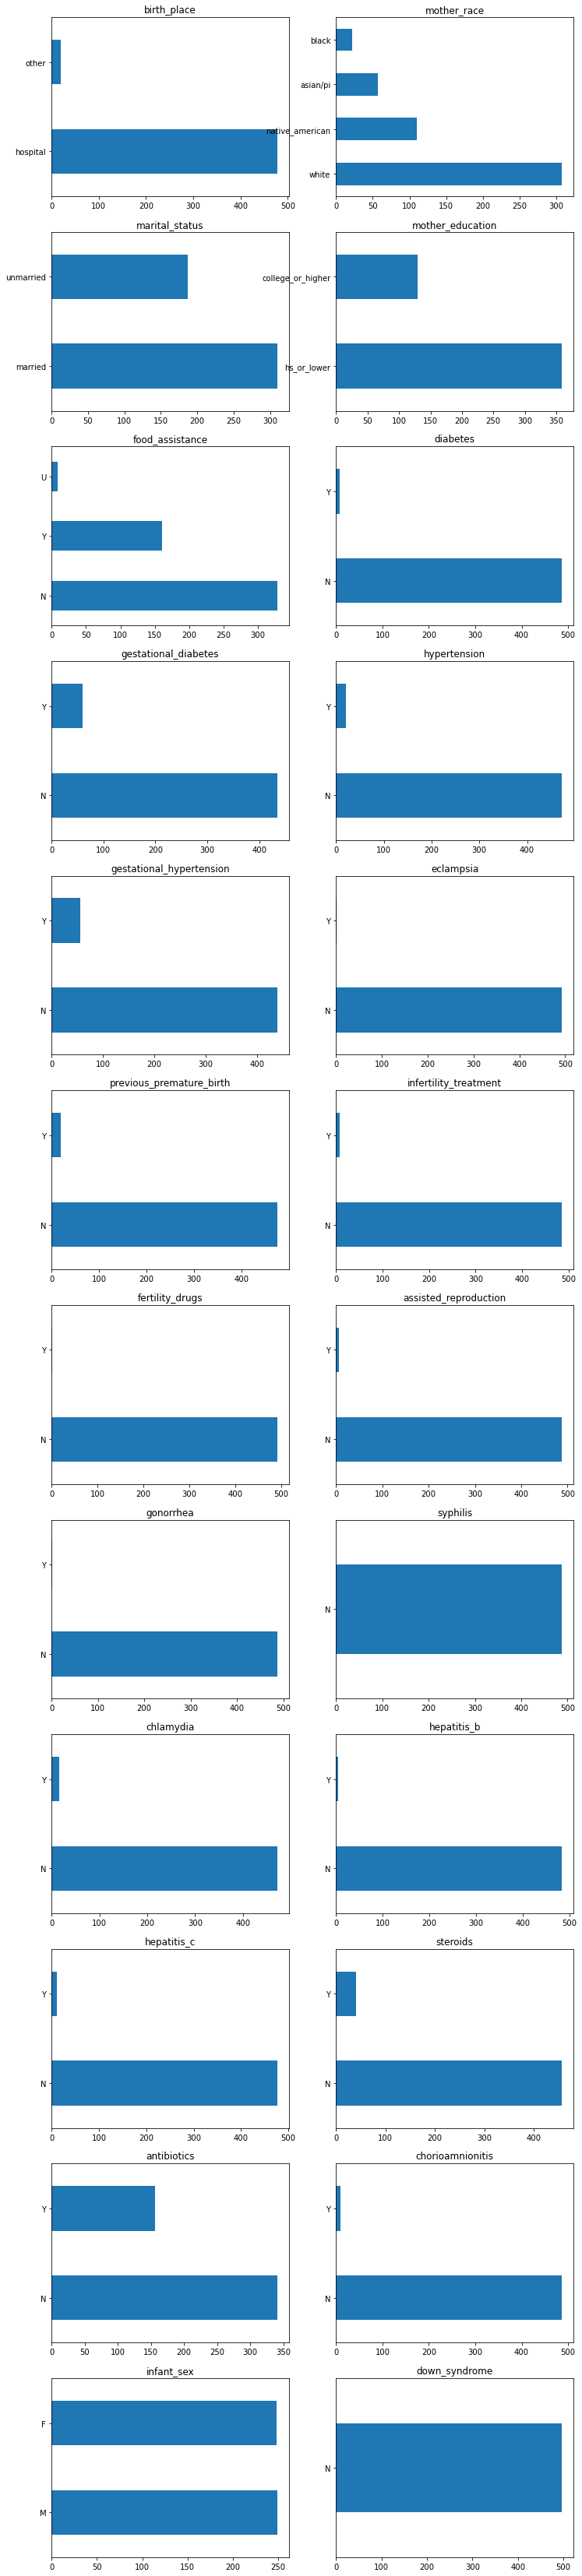

In [148]:
fig, axis = plt.subplots(nrows = int((len(df_cat.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_cat.columns, axis.ravel()):
    df_cat[i].value_counts().plot(kind='barh', ax=subplot, title = i)

<ipython-input-149-db2104ea8bab>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=axis, bins='auto')


array([[<AxesSubplot:title={'center':'mother_age'}>,
        <AxesSubplot:title={'center':'mother_native'}>,
        <AxesSubplot:title={'center':'mother_hispanic'}>,
        <AxesSubplot:title={'center':'father_age'}>,
        <AxesSubplot:title={'center':'living_children'}>],
       [<AxesSubplot:title={'center':'deceased_children'}>,
        <AxesSubplot:title={'center':'terminations'}>,
        <AxesSubplot:title={'center':'months_prenatal_care'}>,
        <AxesSubplot:title={'center':'prenatal_visits'}>,
        <AxesSubplot:title={'center':'prepregnancy_daily_cig'}>],
       [<AxesSubplot:title={'center':'first_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'second_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'third_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'delivery_weight'}>,
        <AxesSubplot:title={'center':'weight_gain'}>,
        <AxesSubplot:tit

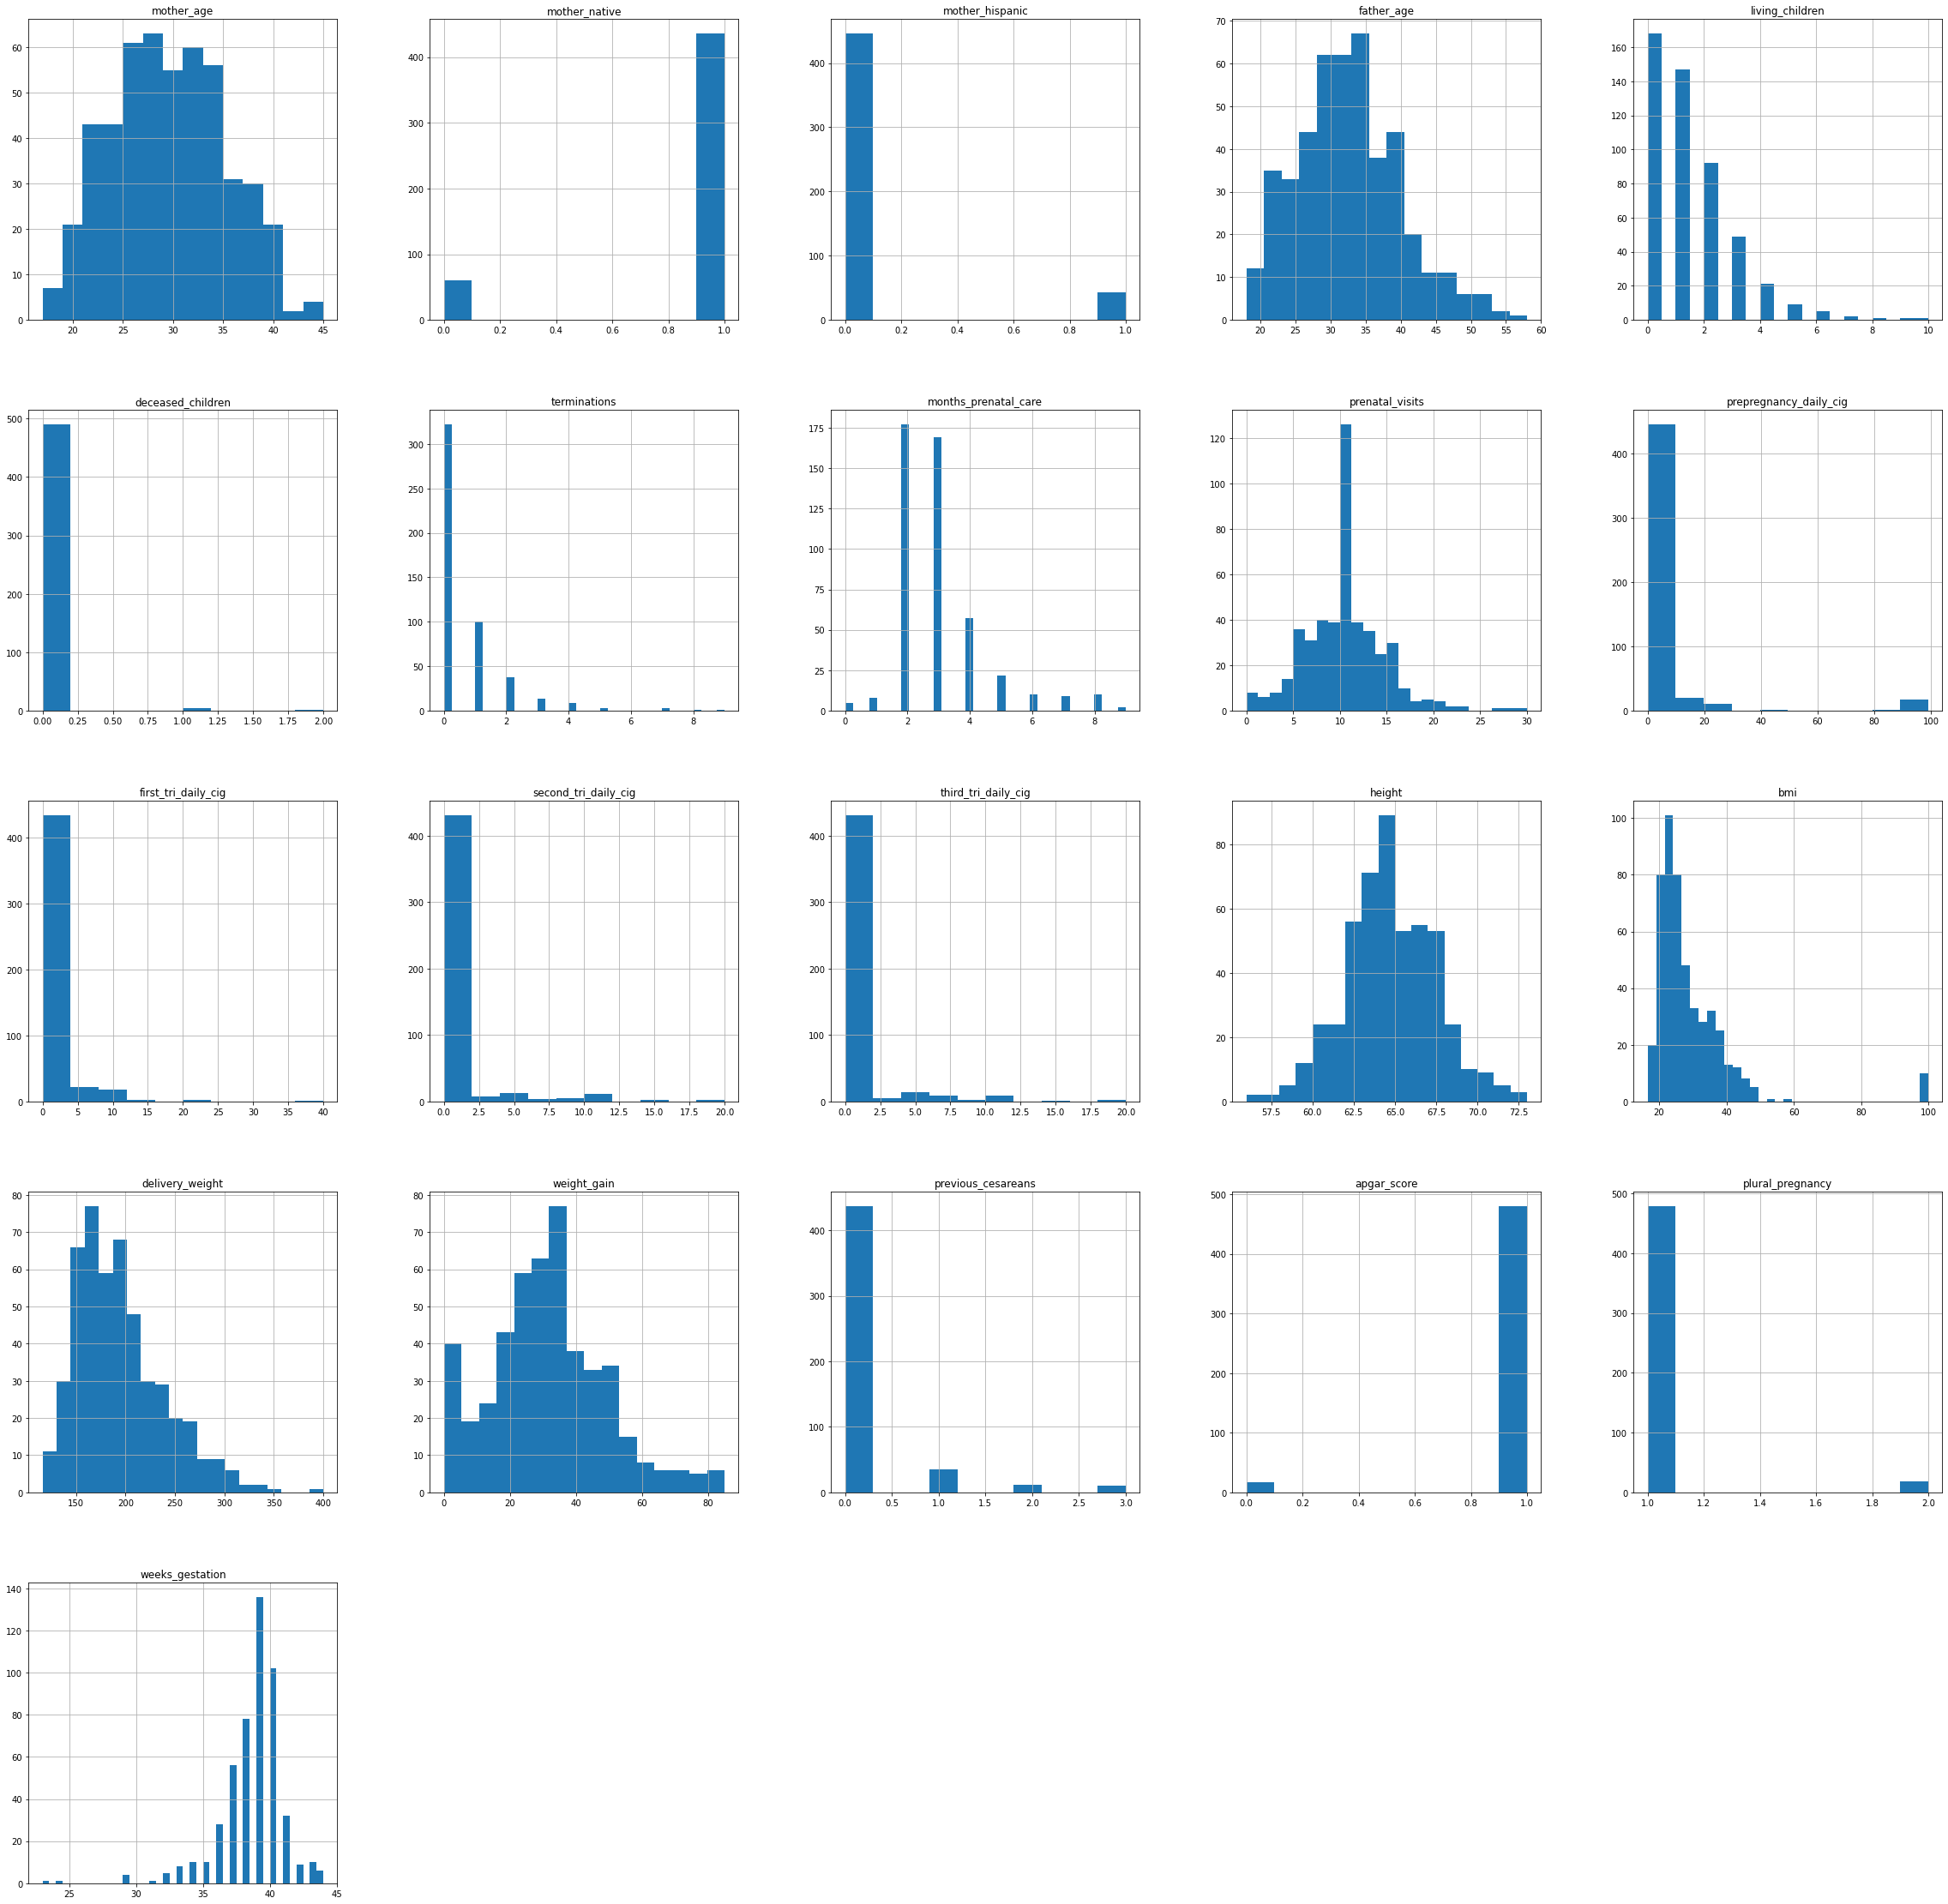

In [149]:
fig, axis = plt.subplots(figsize=(40, 40))
df.hist(ax=axis, bins='auto')

In [150]:
df.isna().sum()

birth_place                  0
mother_age                   0
mother_native                1
mother_race                  0
mother_hispanic              8
marital_status               0
mother_education             9
father_age                  43
living_children              1
deceased_children            1
terminations                 6
months_prenatal_care        28
prenatal_visits             30
food_assistance              0
prepregnancy_daily_cig       0
first_tri_daily_cig         17
second_tri_daily_cig        20
third_tri_daily_cig         23
height                       0
bmi                          0
delivery_weight             10
weight_gain                 21
diabetes                     3
gestational_diabetes         3
hypertension                 3
gestational_hypertension     3
eclampsia                    3
previous_premature_birth     3
infertility_treatment        3
fertility_drugs              3
assisted_reproduction        3
previous_cesareans           4
gonorrhe

## Train Test Split

In [151]:
X = df.drop('apgar_score', axis=1)
y = df['apgar_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27, stratify = df['apgar_score'])

In [152]:
X.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
       'down_syndrome'],
      dtype='object')

In [153]:
df_cat = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(include=['int64', 'float64'])

In [156]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [157]:
dummy_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DummyClassifier(strategy='most_frequent'))]
)

dummy_clf.fit(X_train, y_train)
print("model score: %.3f" % dummy_clf.score(X_test, y_test))

model score: 0.968


In [ ]:
# num_pipe = Pipeline([
#     ('num_selector', ColumnSelector('numerical')),
#     ('num_imputer', SimpleImputer(strategy='constant', fill_value=0))
# ])

# cat_pipe = Pipeline([
#     ('cat_selector', ColumnSelector('categorical')),
#     ('cat_imputer', SimpleImputer(strategy='constant', fill_value='None'))
# ])

# preproc = FeatureUnion([
#     ('num_pipe', num_pipe),
#     ('cat_pipe', cat_pipe)
# ])